# Create an Open-World Split

This notebook details how dataset splits can be created using the example of IRT-CDE. The algorithm to determine *concept entities* and the subsequent selection of *open-world* entities is described in Section 3 of the paper. An implementation of that algorithm can be found in `irt/graph/split.py:Splitter.create`. We first create a `split.Dataset` and then, adding textual information, a `text.Dataset`. These both then form an IRT dataset.

First, a knowledge graph needs to be loaded. We use CoDEx and the loader defined in `irt/graph/loader.py`. Each loader function returns a `irt.graph.GraphImport` instance that is used to instantiate an `irt.graph.Graph`.

In [1]:
%load_ext autoreload
%autoreload 2

You need to have codex cloned:

``` bash
mkdir -p lib
git clone https://github.com/tsafavi/codex lib/codex
```

In [2]:
# create a graph import

import irt
from irt.graph import loader as graph_loader

data_dir = irt.ENV.LIB_DIR / 'codex/data'

source = graph_loader.load_codex(
    data_dir / 'triples/codex-m/train.txt',
    data_dir / 'triples/codex-m/valid.txt',
    data_dir / 'triples/codex-m/test.txt',
    f_ent2id=data_dir / 'entities/en/entities.json',
    f_rel2id=data_dir / 'relations/en/relations.json',
)

In [3]:
# instantiate and persist a graph instance

from irt.graph import graph
g = graph.Graph(name='irt-cde', source=source)

print(str(g))
print(g.description)
g.save(irt.ENV.DATASET_DIR / g.name / 'graph')

irt graph: [irt-cde] (17050 entities)
irt graph: irt-cde
  nodes: 17050
  edges: 206205 (51 types)
  degree:
    mean 24.19
    median 13



## Determine the relation ratio

Each relation has a ratio which we use to determine concept entities.

In [4]:
from irt.graph import split
from tabulate import tabulate

rels = split.Relation.from_graph(g)
rels.sort(key=lambda rel: rel.ratio)


def show_relations(rels, N: int = 10):
    rows = [(i, r.r, r.ratio, len(r.hs), len(r.ts), r.name) for i, r in enumerate(rels, 1)]

    print(f'first {N}')
    print(tabulate(rows[:N]))


print(f'got {len(rels)} relations')
show_relations(rels)

got 51 relations
first 10
--  --  ----------  -----  ---  ------------------------------------------
 1  11  0.00631622   9816   62  P1412:languages spoken, written, or signed
 2  14  0.0104914    3622   38  P1303:instrument
 3  25  0.015873     2520   40  P140:religion
 4   3  0.0168763   13036  220  P27:country of citizenship
 5  19  0.01983       353    7  P30:continent
 6   8  0.0201889    3071   62  P509:cause of death
 7   5  0.0248385    2013   50  P172:ethnic group
 8  41  0.0263158     152    4  P2348:time period
 9  20  0.0275862    2175   60  P102:member of political party
10   2  0.028528    13145  375  P106:occupation
--  --  ----------  -----  ---  ------------------------------------------


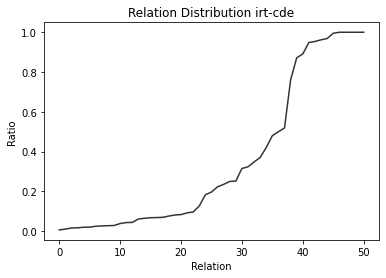

In [5]:
import matplotlib.pyplot as plt

def plot_relations(g, rels):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_title(f'Relation Distribution {g.name}')
    ax.set_xlabel('Relation')
    ax.set_ylabel('Ratio')

    ax.plot(range(len(rels)), [r.ratio for r in rels], color='#333')

plot_relations(g, rels)

After some examination we decide to apply a threshold at relation 27 and exclude some of the selected relations. Additional relations are not included (though this is possible and was applied for IRT-FB).

In [6]:
# define the configuration

cfg = split.Config(
    # make it deterministic
    seed=8051991,
    # select concept entities from the first 27 relations
    threshold=27,
    # retain around 60% of all triples for the cw split
    ow_split=0.6,
    # retain around 50% of all ow triples for testing
    ow_train_split=0.5,
    # exclude some relations
    excludelist=set((
        'P551:residence',
        'P407:language of work or name',
        'P530:diplomatic relation',
    )),
    # do not include additional relations
    includelist=set(),
)

print(cfg)

Config:
  seed: 8051991
  ow split: 0.6
  ow train split: 0.5
  relation threshold: 27
  git: 83c9bbac24e4f11e9a55f28f07a52845cb1e418b
  date: 2021-04-22 16:11:51.741211



In [7]:
# based on this configuration, a split is created

from irt.common import helper
helper.seed(cfg.seed)

path = helper.path(irt.ENV.DATASET_DIR / g.name / 'split', create=True)
splitter = split.Splitter(g=g, cfg=cfg, name=g.name, path=path)
splitter.create()

In [8]:
# we have the raw data saved to an sqlite database
# create the fitting loader and pass it to the text selector

from irt.text import loader as text_loader

database = irt.ENV.SRC_DIR / 'text' / 'cde' / 'contexts-v7-2020-12-31.db'
loader = text_loader.SQLite(database=database)

from irt.text import selector

# this creates the text files in DATASET_DIR / <name> / text

path = helper.path(irt.ENV.DATASET_DIR / g.name, create=True)
selector.create(loader=loader, path=path, seed=cfg.seed, sentences=30, mask=True, mark=True)

SyntaxError: invalid syntax (<ipython-input-8-1cca26cf17d2>, line 9)